<a href="https://colab.research.google.com/github/OlyKoek/MyStudy-AI-app/blob/colab/create_multimodal_embeding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# マルチモーダルなエンベディングモデルの作成

#### 日本語表示対応

In [3]:
# 日本語フォントをダウンロードする。
!apt-get -y install fonts-ipafont-gothic
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'IPAGothic'

import shutil
import os
# フォントキャッシュを削除
font_cache_path = os.path.expanduser("~/.cache/matplotlib")
if os.path.exists(font_cache_path):
    shutil.rmtree(font_cache_path)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


### Pytorchのパッケージと必要なライブラリをインストール
- torch   
- transformers from hugging face
- umap-learn : 可視化で使ってみたい。t-SNEよりも良いらしい
- matplotlib : ベクトル空間の可視化に使用

In [4]:
!pip install torch torchvision torchaudio --quiet
!pip install transformers umap-learn matplotlib pandas scikit-learn --quiet

やりたいことは、マルチモーダルな入力をベクトル空間に投影すること。
今回はできるだけ簡単に構築したいので、下記の構成。

- テキスト：TinyBERT系   
(最初all-MiniLM-L6-v2を使ったけど、日本語使えないことに気が付いたので一旦sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2に変更。東北大学が作った日本語専用のbert-base-japanese-v2もよさげだけど。一旦これで行く。)
- 画像：CLIP
- 音：MCFF

## ■ テキスト

#### テキストのベクトル化

In [5]:
from transformers import AutoTokenizer, AutoModel
import torch

# read TinyBERT model
MODEL_NAME = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

# test sample text
texts = ["今日めっちゃ良かった楽しい","マジつまんね。つらい","今日は普通かな特に何もないし"]

# tokenize
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")


# test ==========================
# view to tokenizerd text
print("-"*50)
text = texts[0]
tokens = tokenizer.tokenize(text)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(f"Tokenizeの出力確認\n\n 入力文章：{text} \nトークン文字：{tokens} \nトークンID: {ids}")
print("-"*50)
# ==============================


# input tokenized data to TinyBERT model
with torch.no_grad():
    outputs = model(**inputs)

# convert token to vector
embeddings = outputs.last_hidden_state.mean(dim=1)
print("\n文数 =",embeddings.shape[0]," ベクトル次元 =", embeddings.shape[1])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


--------------------------------------------------
Tokenizeの出力確認

 入力文章：今日めっちゃ良かった楽しい 
トークン文字：['▁', '今日', 'め', 'っちゃ', '良かった', '楽しい'] 
トークンID: [6, 21834, 8421, 101963, 82989, 82672]
--------------------------------------------------

文数 = 3  ベクトル次元 = 384


### Linearヘッドを追加して256次元に射影

 射影：今回使ったTinyBERTのディフォルトの埋め込みベクトル次元空間を、別のベクトル次元目的空間に変換するための、線形変換を適応

 今回はテキスト以外も同じ特徴空間にプロットするので、共有可能なベクトル次元空間にする必要がある。


In [6]:
import torch.nn as nn

projector = nn.Linear(embeddings.shape[1], 256)

#射影
projected = projector(embeddings)
print(projected.shape)

torch.Size([3, 256])


#### 対象学習　ベクトル同士の意味付け

似た意味の単語を近く人、反対の意味の単語を遠くに、という形でベクトル空間上のプロットを最適化して、自然にクラスタ化されるようにする。


In [7]:
import pandas as pd

data = {
    "anchor": ["嬉しい", "悲しい", "疲れた", "ワクワクする", "寂しい", "楽しい"],
    "positive": ["楽しい", "つらい", "だるい", "楽しみ", "悲しい", "嬉しい"],
    "negative": ["怒っている", "嬉しい", "ワクワクする", "眠い", "明るい", "悲しい"]
}
df = pd.DataFrame(data)
df

,anchor,positive,negative
0,嬉しい,楽しい,怒っている
1,悲しい,つらい,嬉しい
2,疲れた,だるい,ワクワクする
3,ワクワクする,楽しみ,眠い
4,寂しい,悲しい,明るい
5,楽しい,嬉しい,悲しい


In [8]:
from torch.nn import functional as F

def encode_texts(text_list):
  inputs = tokenizer(text_list, padding=True, truncation=True, return_tensors="pt")
  with torch.no_grad():
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

# 各文をエンコード
anchor_emb = encode_texts(df["anchor"].tolist())
pos_emb = encode_texts(df["positive"].tolist())
neg_emb = encode_texts(df["negative"].tolist())

# 正例：anchorとposを近づける
pos_sim = F.cosine_similarity(anchor_emb, pos_emb)
# 負例：anchorとnegを離す
neg_sim = F.cosine_similarity(anchor_emb, neg_emb)

# InfoNCE風のloss（シンプル版）
loss = -torch.log(torch.exp(pos_sim) / (torch.exp(pos_sim) + torch.exp(neg_sim)))
loss = loss.mean()
print(f"Contrastive Loss: {loss.item():.4f}")

Contrastive Loss: 0.5850


In [9]:
optimizer = torch.optim.AdamW(projector.parameters(), lr=1e-4)

for epoch in range(10):
    optimizer.zero_grad()
    anchor_emb = encode_texts(df["anchor"].tolist())
    pos_emb = encode_texts(df["positive"].tolist())
    neg_emb = encode_texts(df["negative"].tolist())

    pos_sim = F.cosine_similarity(projector(anchor_emb), projector(pos_emb))
    neg_sim = F.cosine_similarity(projector(anchor_emb), projector(neg_emb))
    loss = -torch.log(torch.exp(pos_sim) / (torch.exp(pos_sim) + torch.exp(neg_sim))).mean()

    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")


Epoch 1 | Loss: 0.5862
Epoch 2 | Loss: 0.5748
Epoch 3 | Loss: 0.5631
Epoch 4 | Loss: 0.5510
Epoch 5 | Loss: 0.5386
Epoch 6 | Loss: 0.5259
Epoch 7 | Loss: 0.5129
Epoch 8 | Loss: 0.4997
Epoch 9 | Loss: 0.4862
Epoch 10 | Loss: 0.4725


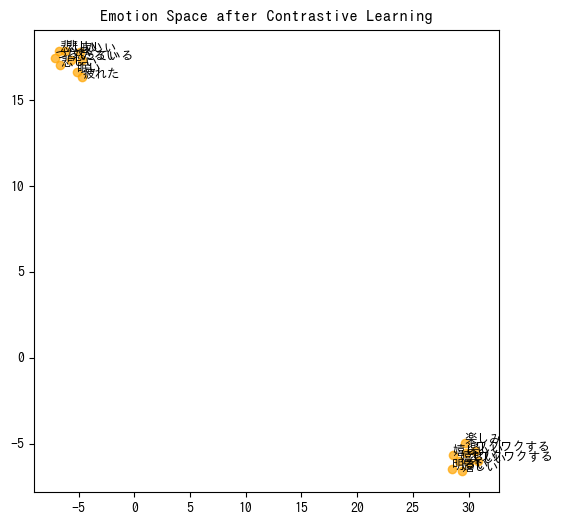

In [10]:
all_texts = df["anchor"].tolist() + df["positive"].tolist() + df["negative"].tolist()
embeddings = encode_texts(all_texts)
projected = projector(embeddings).detach().numpy()

import umap, matplotlib.pyplot as plt
reducer = umap.UMAP(metric="cosine", n_neighbors=5, min_dist=0.3)
umap_emb = reducer.fit_transform(projected)

plt.figure(figsize=(6,6))
plt.scatter(umap_emb[:,0], umap_emb[:,1], c="orange", alpha=0.7)
for i, t in enumerate(all_texts):
    plt.text(umap_emb[i,0], umap_emb[i,1], t, fontsize=9)
plt.title("Emotion Space after Contrastive Learning")
plt.show()
